# Customer Segmentation

This project uses a transactional dataset from an e-commerce retailer, based in the UK, obtained from Kaggle. Transactions range from 01/12/2010 and 09/12/2011. The company sells all-ocassion gifts.

The aim of this project is to segment the customers in the dataset into different customer segments, who can then be targetted with relevant & personalized ads & campaigns by the marketing & digital media teams, on different social media platforms (FB, IG), via video marketing (YouTube), through display marketing (DV360) & email marketing.

The output of this exercise will be mapping Customer ID's to a customer segment on the basis of their historical transactions with the retailer. The segments can then be activated against marketing campaigns on the above-mentioned platforms. 

In [86]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from datetime import timedelta

import matplotlib.pyplot as plt
np.random.seed(42)

plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [87]:
df = pd.read_csv('transactional_data.csv')

In [88]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Cleaning

In [89]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [91]:
df.groupby('Country')['InvoiceNo'].count()

Country
Australia                 1259
Austria                    401
Bahrain                     19
Belgium                   2069
Brazil                      32
Canada                     151
Channel Islands            758
Cyprus                     622
Czech Republic              30
Denmark                    389
EIRE                      8196
European Community          61
Finland                    695
France                    8557
Germany                   9495
Greece                     146
Hong Kong                  288
Iceland                    182
Israel                     297
Italy                      803
Japan                      358
Lebanon                     45
Lithuania                   35
Malta                      127
Netherlands               2371
Norway                    1086
Poland                     341
Portugal                  1519
RSA                         58
Saudi Arabia                10
Singapore                  229
Spain                     2533


### Data Cleaning Steps: 
1. Checking for nulls in the columns that have a non-null count of the less than the total # of rows (541909) - namely Description & CustomerID.
2. The data type of InvoiceDate must be datetime.
3. CustomerID should have data type = string.
4. Removing cancelled orders from the dataset. The rationale is that if an order is cancelled, customers most likely do not like that product, and would not like to be targetted with an ad of the product they cancelled / returned.
5. Removing any entries with country = Unspecified.
6. Removing outliers (very large one-time transactions which can skew the data), defined as being more than 3 std deviations away from the mean in either direction.
7. Removing any entries with a missing Customer ID.

###### Step 1a: Checking for nulls in the 'Description' column and no nulls found

In [92]:
df['Description'].groupby(df['Description'].isna()).count()

Description
False    540455
True          0
Name: Description, dtype: int64

###### Step 1b: Checking for nulls in the 'CustomerID' column and no nulls found

In [93]:
df['CustomerID'].groupby(df['CustomerID'].isna()).count()

CustomerID
False    406829
True          0
Name: CustomerID, dtype: int64

###### Step 2: Converting 'InvoiceDate' into a date field in YYYY-MM-DD format. 

In [94]:
df['Transaction_Date'] = pd.to_datetime(df['InvoiceDate'], yearfirst = True)

###### Step 3: Converting 'CustomerID' from float to string

In [95]:
df['Customer_ID'] = [y[:-2] for y in [str(x) for x in df['CustomerID']]]

Forming a new data df_orders with the cleaned columns. The columns from the raw data are dropped in the cleaned dataset. The remainder of the analysis will use the cleaned dataset 'df_orders'. 

###### Step 4: Removing cancelled / returned orders. 

In [96]:
df_orders = df[df['Quantity'] > 0]
df_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Date,Customer_ID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,17850
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850


###### Step 5: Removing any entries with Country = 'Unspecified'

In [97]:
df_orders = df_orders[(df_orders['Country'] != 'Unspecified') & (df_orders['Country'] != 'EIRE') &
                     (df_orders['Country'] != 'European Community') & (df_orders['Country'] != 'RSA')]

###### Dropping the columns with incorrect data types

In [98]:
df_orders.drop(['InvoiceDate', 'CustomerID'], axis = 1, inplace = True, errors = 'ignore')

In [99]:
df_orders.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Transaction_Date,Customer_ID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,17850
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,17850


In [100]:
df_orders['POS_Sales'] = df['Quantity'] * df['UnitPrice']

In [101]:
df_orders.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Transaction_Date,Customer_ID,POS_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,2010-12-01 08:26:00,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,2010-12-01 08:26:00,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,2010-12-01 08:26:00,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,2010-12-01 08:26:00,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,2010-12-01 08:26:00,17850,20.34


###### Creating an aggregated table at the transactional level

In [102]:
df_transactions = df_orders.pivot_table(index = ['Customer_ID', 'Country', 'InvoiceNo', 'Transaction_Date'], 
                     aggfunc = {'POS_Sales':sum, 'StockCode':len, 'Quantity':sum})

In [103]:
df_transactions.reset_index(inplace = True)

In [104]:
df_transactions.columns

Index(['Customer_ID', 'Country', 'InvoiceNo', 'Transaction_Date', 'POS_Sales',
       'Quantity', 'StockCode'],
      dtype='object')

In [105]:
df_transactions.columns = ['Customer_ID', 'Country', 'InvoiceNo', 'Transaction_Date', 'POS_Sales',
       'Units_Sold', 'Unique_Items_in_Basket']

###### Step 6: Removing outliers. 

Outliers being defined as the sales dollars being 3 std away from the mean on either direction at the InvoiceNo level. 

In [106]:
df_transactions.head()

,Customer_ID,Country,InvoiceNo,Transaction_Date,POS_Sales,Units_Sold,Unique_Items_in_Basket
0,12346,United Kingdom,541431,2011-01-18 10:01:00,77183.60,74215,1
1,12347,Iceland,537626,2010-12-07 14:57:00,711.79,319,31
2,12347,Iceland,542237,2011-01-26 14:30:00,475.39,315,29
3,12347,Iceland,549222,2011-04-07 10:43:00,636.25,483,24
4,12347,Iceland,556201,2011-06-09 13:01:00,382.52,196,18


In [107]:
df_transactions = df_transactions\
[(df_transactions['POS_Sales'] >= df_transactions['POS_Sales'].mean() - 3*df_transactions['POS_Sales'].std()) & 
(df_transactions['POS_Sales'] <= df_transactions['POS_Sales'].mean() + 3*df_transactions['POS_Sales'].std())].dropna()

###### Step 7: Removing customers with a missing Customer ID

In [108]:
df_transactions = df_transactions[df_transactions['Customer_ID'] != 'n']

###### Finding the average time between transactions for the same customer

In [109]:
df_transactions = df_transactions.sort_values(['Customer_ID', 'Transaction_Date'], ascending = (True, True))

In [110]:
df_transactions['Last_Transaction_Date'] = df_transactions.groupby('Customer_ID')['Transaction_Date'].shift(1)

In [111]:
df_transactions['Days_Between_Transactions'] = (df_transactions['Transaction_Date'] - df_transactions['Last_Transaction_Date']).dt.days

In [112]:
df_transactions.head()

,Customer_ID,Country,InvoiceNo,Transaction_Date,POS_Sales,Units_Sold,Unique_Items_in_Basket,Last_Transaction_Date,Days_Between_Transactions
1,12347,Iceland,537626,2010-12-07 14:57:00,711.79,319,31,NaT,NaN
2,12347,Iceland,542237,2011-01-26 14:30:00,475.39,315,29,2010-12-07 14:57:00,49.0
3,12347,Iceland,549222,2011-04-07 10:43:00,636.25,483,24,2011-01-26 14:30:00,70.0
4,12347,Iceland,556201,2011-06-09 13:01:00,382.52,196,18,2011-04-07 10:43:00,63.0
5,12347,Iceland,562032,2011-08-02 08:48:00,584.91,277,22,2011-06-09 13:01:00,53.0


# Creating an Aggregated Table at the Customer Level

The data provided is at the line item level - meaning the data of a single transaction is spread across multiple rows. So, creating a table by aggregating the stats at the Customer_ID level will allow us provide insights at the per customer level, making personalization / audience creation all the more convenient.

In [113]:
df_customer = df_transactions.pivot_table(index = ['Customer_ID', 'Country'], 
                           aggfunc = {'POS_Sales':sum, 'InvoiceNo':len, 'Transaction_Date':max, 
                                      'Days_Between_Transactions':np.mean})

df_customer.reset_index(inplace = True)

In [114]:
df_customer.columns = ['Customer_ID', 'Country', 'Days_Between_Transactions', 'Transaction_Frequency', 
                       'Lifetime_Value', 'Most_Recent_Transaction']

In [115]:
df_customer

,Customer_ID,Country,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Most_Recent_Transaction
0,12347,Iceland,60.333333,7,4310.00,2011-12-07 15:52:00
1,12348,Finland,94.000000,4,1797.24,2011-09-25 13:13:00
2,12349,Italy,NaN,1,1757.55,2011-11-21 09:51:00
3,12350,Norway,NaN,1,334.40,2011-02-02 16:01:00
4,12352,Norway,36.857143,8,2506.04,2011-11-03 14:37:00
...,...,...,...,...,...,...
4330,18280,United Kingdom,NaN,1,180.60,2011-03-07 09:52:00
4331,18281,United Kingdom,NaN,1,80.82,2011-06-12 10:53:00
4332,18282,United Kingdom,118.000000,2,178.05,2011-12-02 11:43:00
4333,18283,United Kingdom,21.800000,16,2094.88,2011-12-06 12:02:00


In [116]:
df_customer['Average_Transaction_Value'] = df_customer['Lifetime_Value'] / df_customer['Transaction_Frequency']

Since the most recent datapoint in the dataset is a date in the past, recency will be calculated relative to the most recent data point in the dataset + 2 days, because the most recent transactions should have a recency value of 1 day.

In [117]:
Max_Date = max(df_customer['Most_Recent_Transaction']) + timedelta(days = 2)

df_customer['Recency_Days'] = (Max_Date - df_customer['Most_Recent_Transaction']).dt.days

In [118]:
df_customer.describe()

,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Average_Transaction_Value,Recency_Days
count,2843.000000,4335.000000,4335.000000,4335.000000,4335.000000
mean,72.033317,4.199539,1717.764024,366.441204,93.691119
std,65.444593,6.987008,4456.384091,345.867003,100.124131
min,0.000000,1.000000,0.000000,0.000000,2.000000
25%,29.000000,1.000000,306.890000,178.271667,19.000000
50%,53.000000,2.000000,668.560000,292.250000,52.000000
75%,91.291667,5.000000,1653.000000,428.076250,144.000000
max,365.000000,211.000000,100913.610000,4873.810000,375.000000


In [119]:
for row, country in enumerate(df_customer['Country']):
    if country == "Channel Islands":
        df_customer['Country'][row] = "United Kingdom"

<ipython-input-119-9657e7499a2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['Country'][row] = "United Kingdom"


# Exploratory Data Analysis

## Customer Distribution by Country

In [120]:
Customers_by_Country = pd.DataFrame(df_customer['Country'].groupby(df_customer['Country']).count())
Customers_by_Country.columns = ['Customer_Count']
Customers_by_Country.reset_index(inplace = True)

In [121]:
Customers_by_Country

,Country,Customer_Count
0,Australia,9
1,Austria,11
2,Bahrain,2
3,Belgium,25
4,Brazil,1
5,Canada,4
6,Cyprus,8
7,Czech Republic,1
8,Denmark,9
9,Finland,12


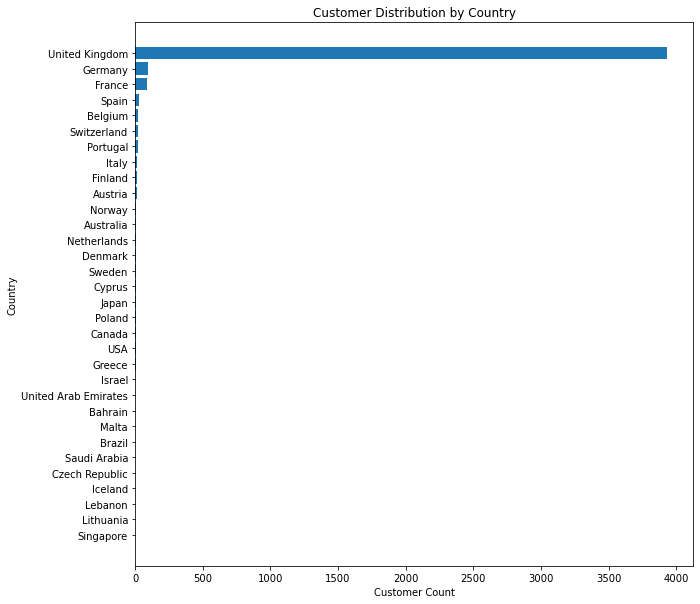

In [122]:
Customers_by_Country.sort_values(by = 'Customer_Count', ascending = True, inplace = True)

plt.figure(figsize = (10,10))
plt.barh(Customers_by_Country['Country'], Customers_by_Country['Customer_Count'])
plt.xlabel('Customer Count')
plt.ylabel('Country')
plt.title('Customer Distribution by Country')
plt.show()

Most customers are from the UK. Let's investigate which countries customers are from, other than the UK. 

<ipython-input-123-925983743251>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Customers_by_Country_other_than_UK.sort_values(by = 'Customer_Count', ascending = True, inplace = True)


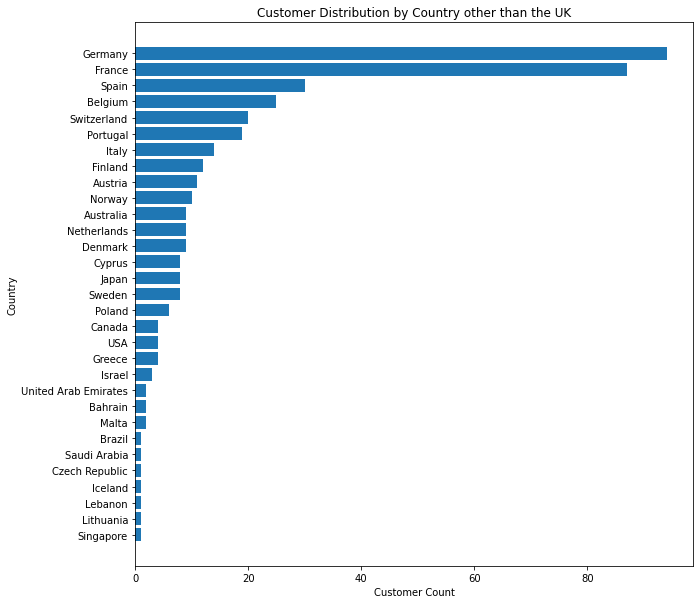

In [123]:
Customers_by_Country_other_than_UK = Customers_by_Country[Customers_by_Country['Country'] != 'United Kingdom']
Customers_by_Country_other_than_UK.sort_values(by = 'Customer_Count', ascending = True, inplace = True)

plt.figure(figsize = (10,10))
plt.barh(Customers_by_Country_other_than_UK['Country'], Customers_by_Country_other_than_UK['Customer_Count'])
plt.xlabel('Customer Count')
plt.ylabel('Country')
plt.title('Customer Distribution by Country other than the UK')
plt.show()

## Time Series Trend in Customer Spending

In [124]:
df_transactions['Transaction_Date'] = pd.to_datetime(df_transactions['Transaction_Date']).dt.date

In [125]:
df_transactions_daily = df_transactions.pivot_table(index = 'Transaction_Date', 
                                                    aggfunc = {'POS_Sales':sum, 'InvoiceNo':len, 
                                                               'Customer_ID':lambda x: len(x.unique())})

df_transactions_daily.columns = ['Customer_Count', 'Transaction_Frequency', 'Sum_POS_Sales']

df_transactions_daily['Average_Order_Value'] = df_transactions_daily['Sum_POS_Sales'] / df_transactions_daily['Transaction_Frequency']
df_transactions_daily['Average_Spend'] = df_transactions_daily['Sum_POS_Sales'] / df_transactions_daily['Customer_Count']

df_transactions_daily.head()

,Customer_Count,Transaction_Frequency,Sum_POS_Sales,Average_Order_Value,Average_Spend
Transaction_Date,,,,,
2010-12-01,94,120,45821.11,381.842583,487.458617
2010-12-02,98,136,47294.03,347.750221,482.592143
2010-12-03,48,55,21893.86,398.070182,456.122083
2010-12-05,75,87,31771.60,365.190805,423.621333
2010-12-06,81,91,30033.14,330.034505,370.779506


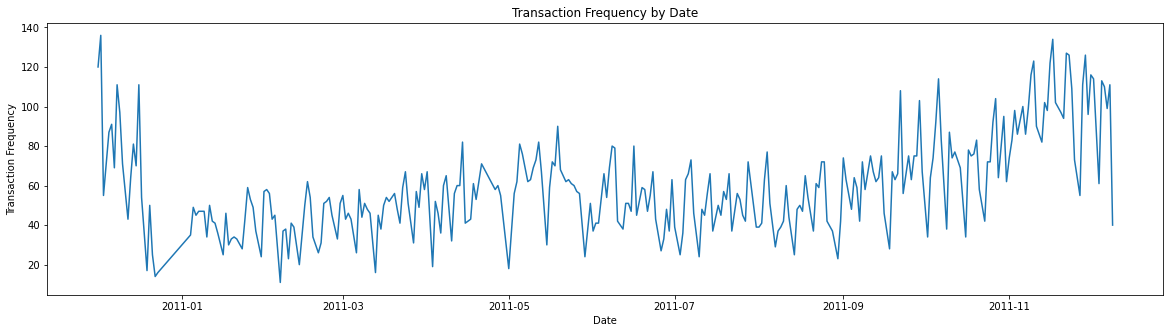

In [126]:
plt.figure(figsize = (20,5))
plt.plot(df_transactions_daily['Transaction_Frequency'])
plt.title('Transaction Frequency by Date')
plt.xlabel('Date')
plt.ylabel('Transaction Frequency')
plt.show()

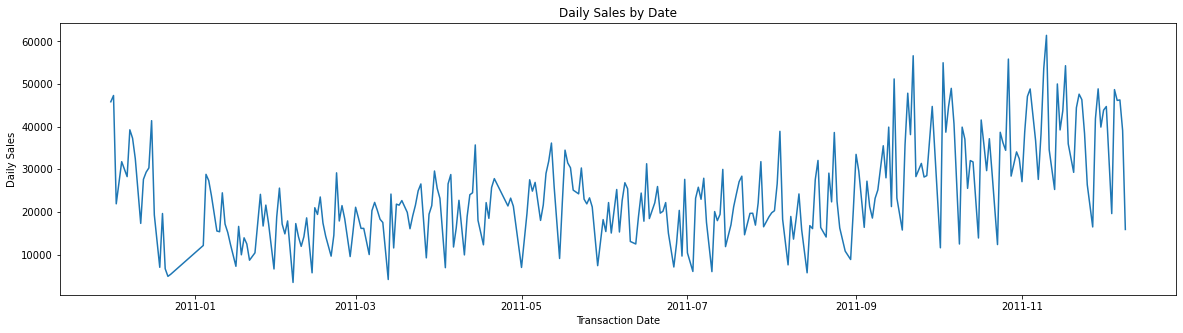

In [127]:
plt.figure(figsize = (20,5))
plt.plot(df_transactions_daily['Sum_POS_Sales'])
plt.title('Daily Sales by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Daily Sales')
plt.show()

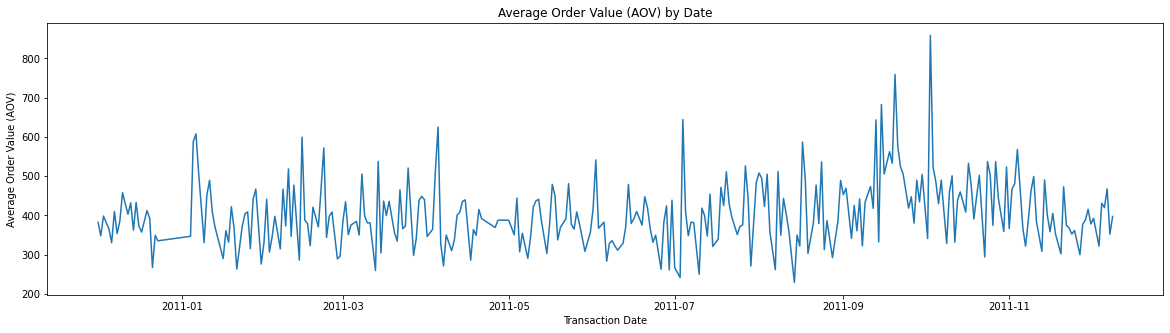

In [128]:
plt.figure(figsize = (20,5))
plt.plot(df_transactions_daily['Average_Order_Value'])
plt.title('Average Order Value (AOV) by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Average Order Value (AOV)')
plt.show()

The daily transactional data might be too granular to notice a discernable trend. It might be better to aggregate the data at a higher level of granularity (monthly level) to see more of a pattern bubble up.

In [129]:
df_transactions_daily.reset_index(inplace = True)
df_transactions_daily['Transaction_Date'] = pd.to_datetime(df_transactions_daily['Transaction_Date'])

In [130]:
df_transactions_monthly = df_transactions_daily.groupby([pd.Grouper(key = 'Transaction_Date', freq = 'M')]).agg({'Transaction_Frequency': sum, 'Sum_POS_Sales':sum})

In [131]:
df_transactions_monthly['Average_Order_Value'] = df_transactions_monthly['Sum_POS_Sales'] / df_transactions_monthly['Transaction_Frequency']

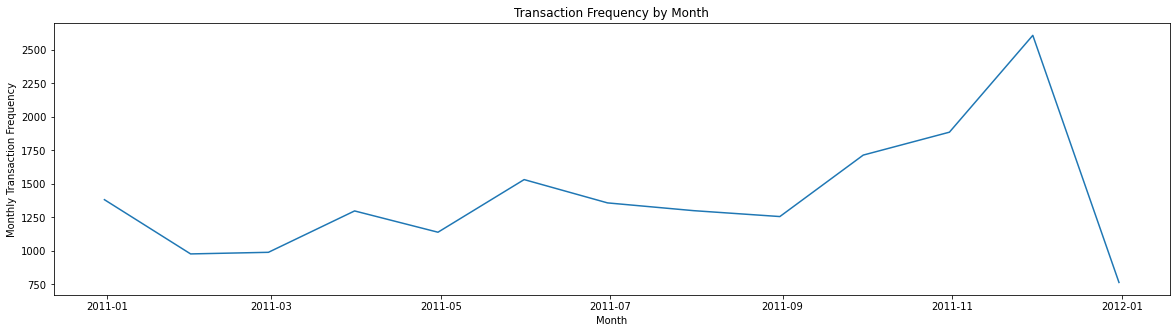

In [132]:
plt.figure(figsize = (20,5))
plt.plot(df_transactions_monthly['Transaction_Frequency'])
plt.title('Transaction Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Monthly Transaction Frequency')
plt.show()

There seems to be an increasing trend in transaction frequency in the months leading up to Christmas, with an all-time high transaction frequency seen in the month of December (2011-12).

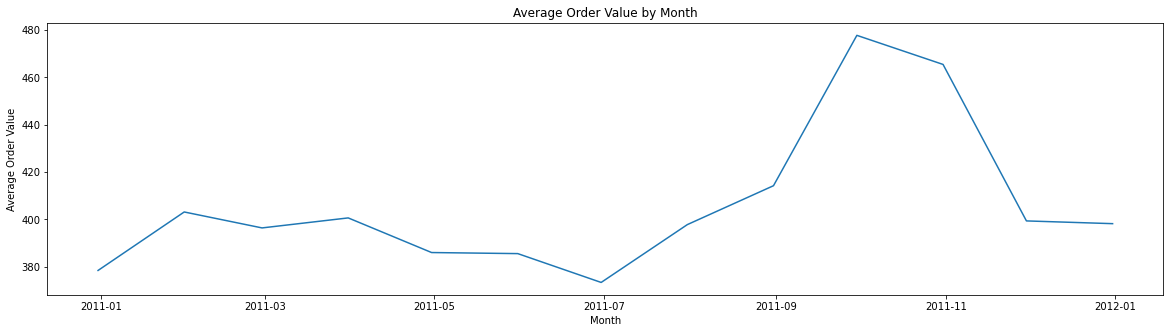

In [133]:
plt.figure(figsize = (20,5))
plt.plot(df_transactions_monthly['Average_Order_Value'])
plt.title('Average Order Value by Month')
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.show()

The size of each individual transaction / order, also known as Average Order Value (AOV) has an increasing trend, starting July-2011, reaching an all-time high in Nov-2011. This indicates that customers could be doing Black Friday shopping, buying Christmas presents for friends & family. The spending level drops down after November.

# Customer Spend Bands

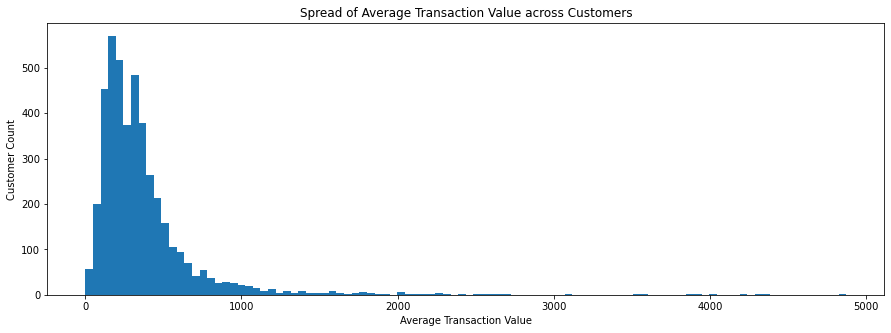

In [134]:
plt.figure(figsize = (15,5))
plt.hist(df_customer['Average_Transaction_Value'], bins = 100)
plt.xlabel('Average Transaction Value')
plt.ylabel('Customer Count')
plt.title('Spread of Average Transaction Value across Customers')
plt.show()

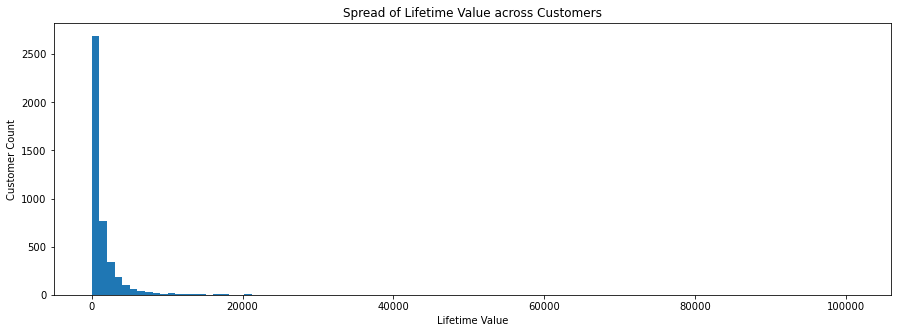

In [135]:
plt.figure(figsize = (15,5))
plt.hist(df_customer['Lifetime_Value'], bins = 100)
plt.xlabel('Lifetime Value')
plt.ylabel('Customer Count')
plt.title('Spread of Lifetime Value across Customers')
plt.show()

The spread of customers, in terms of Average Transaction Value & Lifetime Value, are right skewed distributions, indicating most of the retailer's customers would fall in the lower spend bands, and a small handful of customers would be in the higher spend bands. 

## Problem Statement

The retailer is looking to come up with a marketing strategy for different customer types in its ecosystem. Each customer type will be targetted differently with marketing campaigns. 

For instance, high spending customers will be given personalized premium service and will be offered to opt-in to the company's loyalty program. Low spending customers, who are on the verge of churning, could be given discounts & coupons to retain them and prevent from going to a competitor. 

This problem will use unsupervised learning and will use different clustering techniques to distinctly segregate customers into one of 4 categories:
1. Customers in a 'High' spend band
2. Customers in a 'Medium' spend band
3. Customers in a 'Low' spend band
4. Churned customers

# Feature Engineering

The inputs to the algorithm will consist of 3 types of metrics - 

1. Recency Metrics - When were the customer's most recent transactions with the retailer? 
This can be measured by 'Recency_Days', which is the delta in days of the customer's most recent transaction with the retailer, from the most recent transaction date on the dataset. 


2. Frequency Metrics - How frequently is the customer transacting with the retailer? This can be measured by 2 metrics - 

    1. Transaction_Frequency
    2. Days_Between_Transactions


3. Monetary Metrics - This is measured by 2 metrics - 

    1. Lifetime_Value - The total spend of the customer with the retailer
    2. Average_Transaction_Value - The average value of every transaction / order of that customer with the retailer

# Preprocessing data for K-Means Clustering

There are 2 prerequisites to applying clustering algorithms:
1. The data must be normally distributed (i.e, the data cannot be skewed).
2. The data must be normalized to a mean of 0 and a standard deviation of 1, so that all features have an equal weight/significance in the clustering algorithm. 

### Applying Transformations to make the data normally distributed

A logarithmic transformation will be applied to the dataframe to ensure the inputs to the clustering algorithm is as normal as possible. Any value with 0 is removed because log(0) is undefined. Any customer with 0 for any of the recency, frequency, monetary metrics will be assumed to have churned. 

In [136]:
df_customer_clustering = df_customer[['Transaction_Frequency', 'Lifetime_Value', 'Recency_Days', 
                                      'Days_Between_Transactions', 'Average_Transaction_Value']]

df_customer_clustering = df_customer_clustering[(df_customer_clustering['Transaction_Frequency'] > 1)  
                        & (df_customer_clustering['Lifetime_Value'] > 0) & (df_customer_clustering['Recency_Days'] > 0)
                        & (df_customer_clustering['Days_Between_Transactions'] > 0) & (df_customer_clustering['Average_Transaction_Value'] > 0)]

df_customer_cleaned = df_customer[(df_customer['Transaction_Frequency'] > 1)  & (df_customer['Lifetime_Value'] > 0) 
                        & (df_customer['Recency_Days'] > 0) & (df_customer['Days_Between_Transactions'] > 0)
                        & (df_customer['Average_Transaction_Value'] > 0)] 

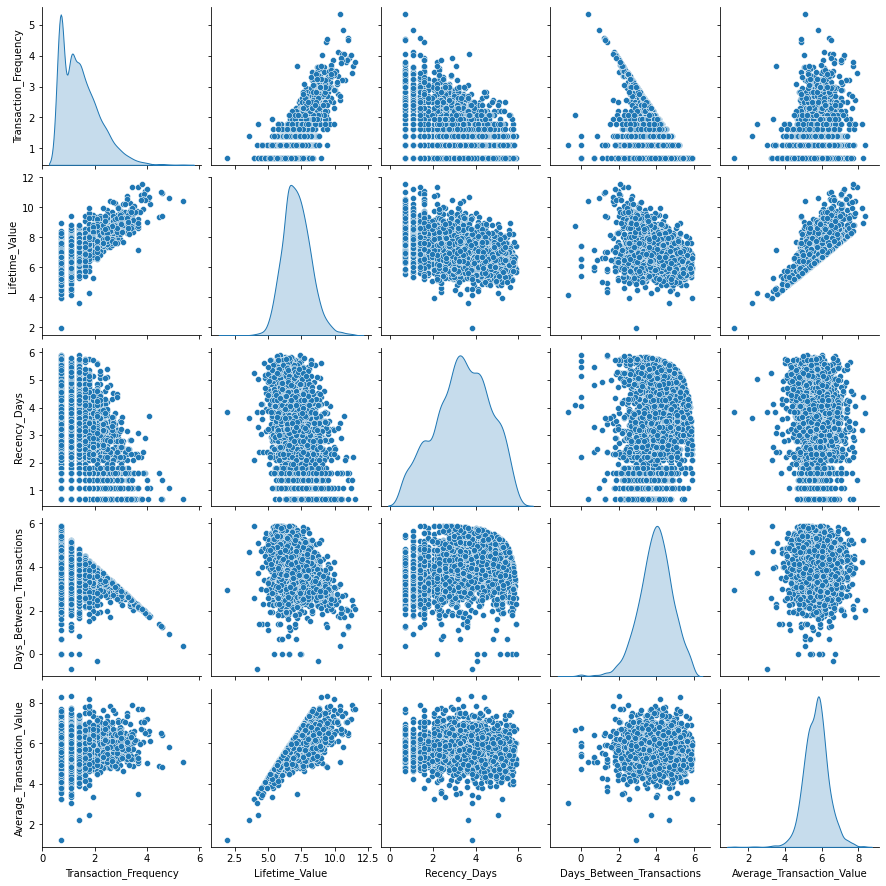

In [137]:
df_customer_log = np.log(df_customer_clustering)

sns.pairplot(df_customer_log, diag_kind = 'kde')
plt.show()

Although the data points are not perfectly symmetrical, there is still some skewness - a left/right tail can be seen for some of the variables.

### Scaling & Centering the data

In [138]:
df_customer_clustering.describe()

,Transaction_Frequency,Lifetime_Value,Recency_Days,Days_Between_Transactions,Average_Transaction_Value
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,5.961428,2472.424406,58.025234,73.643735,372.442317
std,8.200272,5414.657080,68.022981,65.260366,308.056217
min,2.000000,6.900000,2.000000,0.500000,3.450000
25%,2.000000,629.692500,12.000000,30.500000,194.568750
50%,4.000000,1187.005000,30.500000,54.000000,304.433594
75%,7.000000,2466.882500,75.000000,93.000000,441.472500
max,211.000000,100913.610000,367.000000,365.000000,4200.610000


In [139]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
Scaler.fit(df_customer_log)
df_customer_scaled_transformed = Scaler.transform(df_customer_log)
df_customer_scaled_transformed = pd.DataFrame(data = df_customer_scaled_transformed, columns = df_customer_clustering.columns)
round(df_customer_scaled_transformed.describe(),2)

,Transaction_Frequency,Lifetime_Value,Recency_Days,Days_Between_Transactions,Average_Transaction_Value
count,2774.00,2774.00,2774.00,2774.00,2774.00
mean,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.06,-4.98,-2.13,-5.16,-6.76
25%,-1.06,-0.67,-0.71,-0.58,-0.65
50%,-0.09,-0.07,0.03,0.05,0.03
75%,0.69,0.63,0.74,0.66,0.60
max,5.44,4.17,2.00,2.18,4.01


Since all variables now have a mean of 0 and a standard deviation of 1, the data has been successfully scaled so that all variables have similar means & standard deviations / variances.

Running clustering with KMeans first, initiliazing with 3 clusters.

In [140]:
from sklearn.cluster import KMeans
Kmeans = KMeans(n_clusters = 3, random_state = 1234)
Kmeans.fit(df_customer_scaled_transformed)
y_Kmeans = Kmeans.predict(df_customer_scaled_transformed)
df_customer_kmeans_3 = df_customer_cleaned.assign(Cluster = Kmeans.labels_)
df_customer_kmeans_3_scaled_transformed = df_customer_scaled_transformed.assign(Cluster = Kmeans.labels_)
df_customer_kmeans_3.head()

,Customer_ID,Country,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Most_Recent_Transaction,Average_Transaction_Value,Recency_Days,Cluster
0,12347,Iceland,60.333333,7,4310.00,2011-12-07 15:52:00,615.714286,3,1
1,12348,Finland,94.000000,4,1797.24,2011-09-25 13:13:00,449.310000,76,2
4,12352,Norway,36.857143,8,2506.04,2011-11-03 14:37:00,313.255000,37,1
8,12356,Portugal,151.000000,3,2811.43,2011-11-17 08:40:00,937.143333,24,2
9,12358,Austria,149.000000,2,1168.06,2011-12-08 10:26:00,584.030000,3,2


In [141]:
kmeans3_average_scaled_transformed = df_customer_kmeans_3_scaled_transformed.groupby('Cluster').mean()
kmeans3_average = df_customer_kmeans_3.groupby('Cluster').mean()
kmeans3_average

,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Average_Transaction_Value,Recency_Days
Cluster,,,,,
0,87.348742,3.122002,530.007468,175.232250,81.293014
1,31.575931,12.479064,5780.934828,444.414597,17.759852
2,94.596831,3.399801,1651.155594,502.734403,68.375872


So, we can see 3 clusters here -> 

Cluster 0: The low frequency, low spend band

Cluster 1: High frequency, high spend band

Cluster 2: Low frequency, high spend band

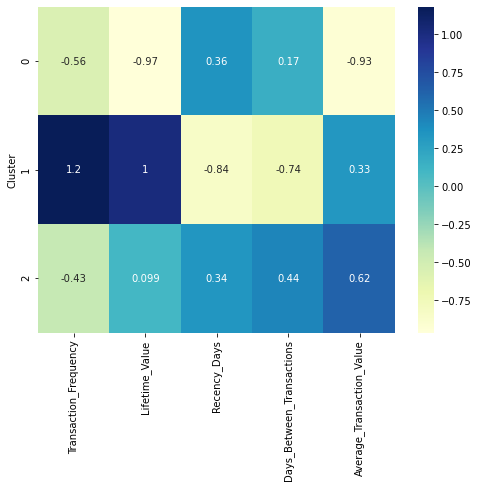

In [148]:
sns.heatmap(kmeans3_average_scaled_transformed, cmap = 'YlGnBu', annot = True)
plt.show()

The heatmap shows the impact of each of the features on the final outcome of the clustering.

In [149]:
df_customer_kmeans_3.head()

,Customer_ID,Country,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Most_Recent_Transaction,Average_Transaction_Value,Recency_Days,Cluster
0,12347,Iceland,60.333333,7,4310.00,2011-12-07 15:52:00,615.714286,3,1
1,12348,Finland,94.000000,4,1797.24,2011-09-25 13:13:00,449.310000,76,2
4,12352,Norway,36.857143,8,2506.04,2011-11-03 14:37:00,313.255000,37,1
8,12356,Portugal,151.000000,3,2811.43,2011-11-17 08:40:00,937.143333,24,2
9,12358,Austria,149.000000,2,1168.06,2011-12-08 10:26:00,584.030000,3,2


Since there are 5 variables to be plotted and only 3 can be plotted at one time - I have plotted 1 recency metric, 1 frequency metric & 1 recency metric in each scatter plot.

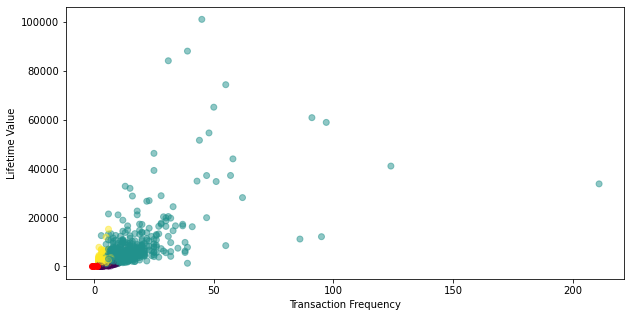

In [150]:
plt.figure(figsize = (10,5))

plt.scatter(df_customer_kmeans_3['Transaction_Frequency'], df_customer_kmeans_3['Lifetime_Value'],  
            c = y_Kmeans, alpha = 0.5, cmap = 'viridis')

plt.xlabel('Transaction Frequency')
plt.ylabel('Lifetime Value')

centers = Kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:,2], c = 'red', marker = 'o', alpha = 1)

plt.show()

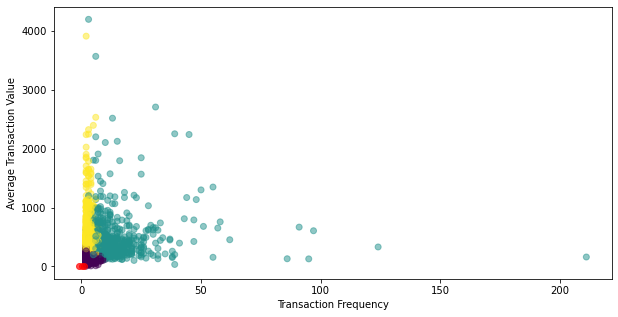

In [151]:
plt.figure(figsize = (10,5))

plt.scatter(df_customer_kmeans_3['Transaction_Frequency'], df_customer_kmeans_3['Average_Transaction_Value'], 
            c = y_Kmeans, alpha = 0.5, cmap = 'viridis')

plt.xlabel('Transaction Frequency')
plt.ylabel('Average Transaction Value')

centers = Kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:,3], c = 'red', marker = 'o', alpha = 0.7)

plt.show()

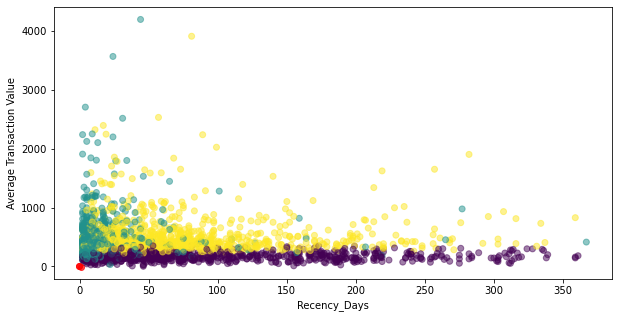

In [152]:
plt.figure(figsize = (10,5))

plt.scatter(df_customer_kmeans_3['Recency_Days'], df_customer_kmeans_3['Average_Transaction_Value'], 
            c = y_Kmeans, alpha = 0.5, cmap = 'viridis')

plt.xlabel('Recency_Days')
plt.ylabel('Average Transaction Value')

centers = Kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:,3], c = 'red', marker = 'o', alpha = 0.7)

plt.show()

3 clusters can be seen, but the clusters don't have a distinct boundary. 

Principal Component Analysis (PCA) can be performed on the data, which would reduce 5 features to 2, which would in turn, make the data more easy to be visualized by the human eye. Clustering can also be done following PCA to see if distinct cluster boundaries emerge.

###### Applying the Elbow Transformation Rule to find the right # of clusters

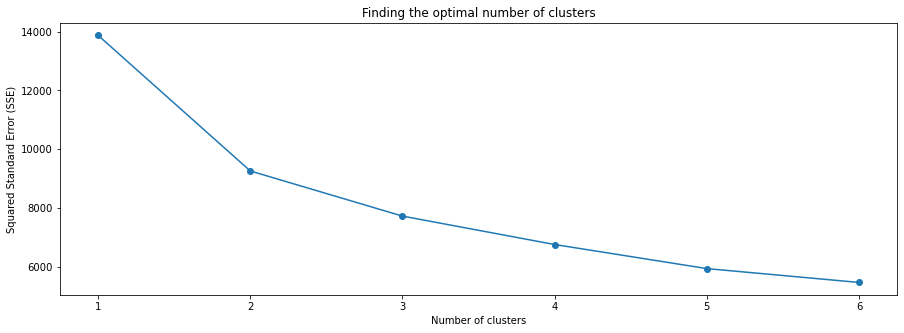

In [153]:
SSE = {}

for k in range(1, 7):
    kmeans = KMeans(n_clusters = k, random_state = 1234)
    kmeans.fit(df_customer_scaled_transformed)
    SSE[k] = kmeans.inertia_

plt.figure(figsize = (15,5))
plt.plot(list(SSE.keys()), list(SSE.values()), marker = 'o')
plt.title('Finding the optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Squared Standard Error (SSE)')
plt.show()

So, from the graph we can see that 3 clusters gives the most significant drop in SSE. Having more than 3 clusters gives diminishing returns on the SSE. 

##### Principal Component Analysis

In [154]:
from sklearn.decomposition import PCA

PCA_Initializer = PCA(n_components = 2)
PC_Customer_Type = PCA_Initializer.fit_transform(df_customer_clustering)

PC_Customer_Type = pd.DataFrame(PC_Customer_Type)
PC_Customer_Type.columns = ['PC1', 'PC2']

PC_Customer_Type.head()

,PC1,PC2
0,1843.877594,190.623380
1,-672.827436,96.390747
2,32.071837,-60.910636
3,354.733611,556.001903
4,-1297.918976,249.388337


Performing K-Means clustering on the dataset after performing Principal Component Analysis on it.

In [155]:
from sklearn.cluster import KMeans
Kmeans_3_PCA = KMeans(n_clusters = 3, random_state = 1234)
Kmeans_3_PCA.fit(PC_Customer_Type)
y_Kmeans_3 = Kmeans_3_PCA.predict(PC_Customer_Type)
df_customer_PCA = PC_Customer_Type.assign(Cluster = Kmeans_3_PCA.labels_)
df_customer_PCA_clusters = df_customer_cleaned.assign(Cluster = Kmeans.labels_)

df_customer_PCA.head()

,PC1,PC2,Cluster
0,1843.877594,190.623380,0
1,-672.827436,96.390747,0
2,32.071837,-60.910636,0
3,354.733611,556.001903,0
4,-1297.918976,249.388337,0


In [156]:
PCA_average = df_customer_PCA_clusters.groupby('Cluster').mean()
PCA_average

,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Average_Transaction_Value,Recency_Days
Cluster,,,,,
0,87.348742,3.122002,530.007468,175.232250,81.293014
1,31.575931,12.479064,5780.934828,444.414597,17.759852
2,94.596831,3.399801,1651.155594,502.734403,68.375872


We can see 3 distinct segments here -> 

1. Cluster 1: High frequency, high spending customer (High)
2. Cluster 0: Low frequency, low spending customer (Low)
3. Cluster 2: Low frequency, high spending customer (Medium)

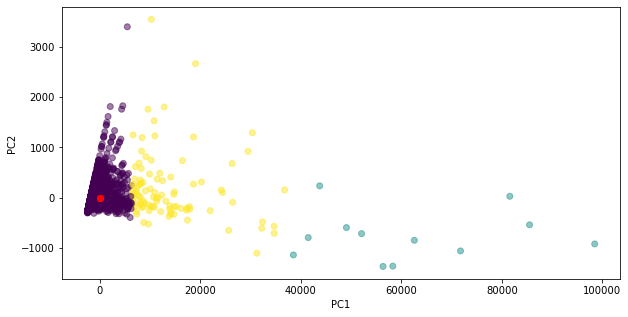

In [157]:
plt.figure(figsize = (10,5))

plt.scatter(df_customer_PCA['PC1'], df_customer_PCA['PC2'], c = y_Kmeans_3, alpha = 0.5, cmap = 'viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')

centers_3 = Kmeans_3_PCA.cluster_centers_
plt.scatter(centers[:, 0], centers[:,1], c = 'red', marker = 'o', alpha = 1)

plt.show()

Applying a PCA transformation has caused distinct cluster boundaries to emerge. 

###### Applying Elbow Criterion to find the right # of clusters

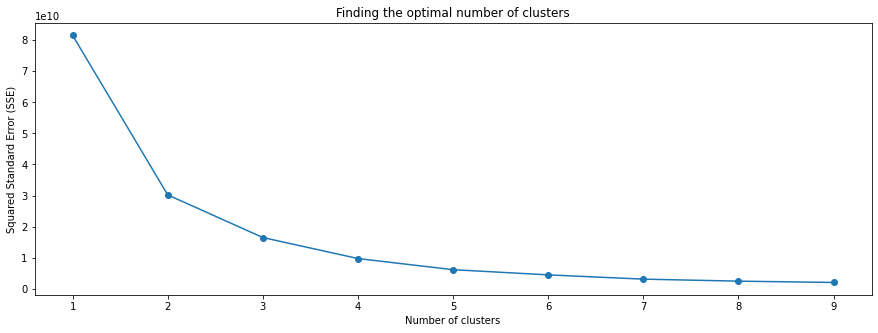

In [158]:
SSE_k = {}

for k in range(1, 10):
    Kmeans_k = KMeans(n_clusters = k, random_state = 1234)
    Kmeans_k.fit(PC_Customer_Type)
    SSE_k[k] = Kmeans_k.inertia_

plt.figure(figsize = (15,5))
plt.plot(list(SSE_k.keys()), list(SSE_k.values()), marker = 'o')
plt.title('Finding the optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Squared Standard Error (SSE)')
plt.show()

Applying elbow criterion shows 3 clusters once again is the most optimal # of clustering, before starting to get diminishing returns on the SSE.

In [159]:
df_customer = df_customer.merge(df_customer_PCA_clusters, how = 'left', on = 'Customer_ID')
df_customer.drop(df_customer.filter(regex='_y').columns.tolist(),axis=1, inplace=True)

In [160]:
df_customer.columns = [column.rstrip("_x") for column in df_customer.columns]

In [161]:
df_customer['Customer_Segment'] = df_customer['Cluster'].map({1:'High Spend', 0:'Low Spend', 2:'Medium Spend', np.NaN:'Churned'})

In [162]:
df_customer

,Customer_ID,Country,Days_Between_Transactions,Transaction_Frequency,Lifetime_Value,Most_Recent_Transaction,Average_Transaction_Value,Recency_Days,Cluster,Customer_Segment
0,12347,Iceland,60.333333,7,4310.00,2011-12-07 15:52:00,615.714286,3,1.0,High Spend
1,12348,Finland,94.000000,4,1797.24,2011-09-25 13:13:00,449.310000,76,2.0,Medium Spend
2,12349,Italy,NaN,1,1757.55,2011-11-21 09:51:00,1757.550000,20,NaN,Churned
3,12350,Norway,NaN,1,334.40,2011-02-02 16:01:00,334.400000,311,NaN,Churned
4,12352,Norway,36.857143,8,2506.04,2011-11-03 14:37:00,313.255000,37,1.0,High Spend
...,...,...,...,...,...,...,...,...,...,...
4336,18280,United Kingdom,NaN,1,180.60,2011-03-07 09:52:00,180.600000,279,NaN,Churned
4337,18281,United Kingdom,NaN,1,80.82,2011-06-12 10:53:00,80.820000,182,NaN,Churned
4338,18282,United Kingdom,118.000000,2,178.05,2011-12-02 11:43:00,89.025000,9,0.0,Low Spend
4339,18283,United Kingdom,21.800000,16,2094.88,2011-12-06 12:02:00,130.930000,5,1.0,High Spend


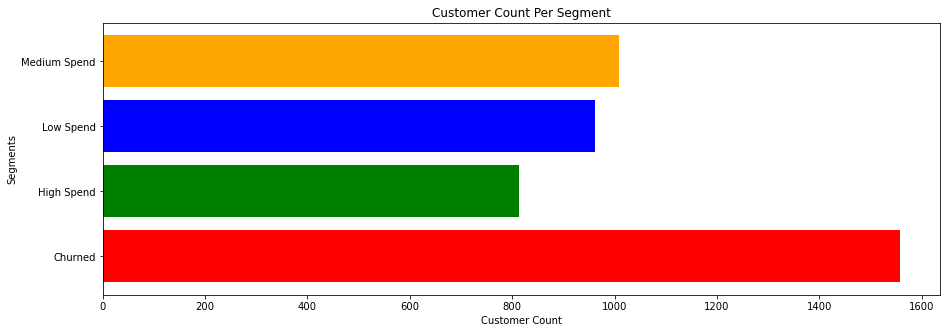

In [163]:
Customer_Count_Segment = pd.DataFrame(df_customer.groupby(df_customer['Customer_Segment'])['Customer_ID'].count())
Customer_Count_Segment.reset_index(inplace = True)

plt.figure(figsize = (15,5))
plt.barh(Customer_Count_Segment['Customer_Segment'], Customer_Count_Segment['Customer_ID'], color = ['red', 'green', 'blue', 'orange'])
plt.xlabel('Customer Count')
plt.title('Customer Count Per Segment')
plt.ylabel('Segments')
plt.show()

There is a large opportunity for the retailer, to have campaigns, promos & coupons to retain the churned customer segment, because a large part of the retailer's customers seem to transact just a few times and never come back. 

The target of this would be to convert the churned customers into low spending customers, the low spending customers to medium spending and those in the medium spend band to the high spend band.